In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!nvidia-smi

Wed Jan 28 18:45:37 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

--2026-01-28 18:45:37--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  50.6MB/s    in 3.5s    

2026-01-28 18:45:41 (46.3 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


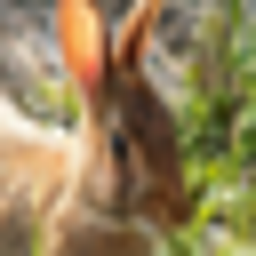

In [5]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [0, 33, 65]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCWC -> NWHC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

Image.fromarray(train_X[10]).resize((256,256))

In [6]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7e8a30f22060>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e8a30f21940>}

In [7]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nchw

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.hidden_size = hidden_size
        self.classes = classes
        self.seq = nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),

            nn.Conv2d(3, HIDDEN_SIZE, 5, stride=2, padding=2),
            nn.BatchNorm2d(HIDDEN_SIZE),
            nn.Dropout(0.4),
            nn.ReLU(),

            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, 3, stride=1, padding=1),
            nn.BatchNorm2d(HIDDEN_SIZE*2),
            nn.ReLU(),

            nn.MaxPool2d(4),
            nn.Flatten(),

            nn.Linear(2048, classes),
        )

    def forward(self, input):
        return self.seq(input)

    # Пуллинг с помощью шага свёртки stride
    def stridePulling(self):
       return nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            nn.Conv2d(3, self.hidden_size, 5, stride=4, padding=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.hidden_size * 8 * 8, self.classes),
        ).to(device)

    # Макс пуллинг
    def maxPulling(self):
       return nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            nn.Conv2d(3, self.hidden_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(self.hidden_size * 8 * 8, self.classes),
        ).to(device)

    # Усредняющий пуллинг
    def averagePulling(self):
       return nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            nn.Conv2d(3, self.hidden_size, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),
            nn.Flatten(),
            nn.Linear(self.hidden_size * 8 * 8, self.classes),
        ).to(device)

HIDDEN_SIZE = 64
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model.to(device)
model
print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))

tensor([[0.9453, 0.3261, 0.2530]], device='cuda:0', grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 64, 16, 16]           4,864
       BatchNorm2d-3           [-1, 64, 16, 16]             128
           Dropout-4           [-1, 64, 16, 16]               0
              ReLU-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                    [-1, 3]           6,147
Total params: 85,251
Trainable params: 85,251
Non-trainable params: 0
-------------------

  0%|          | 0/3000 [00:00<?, ?it/s]

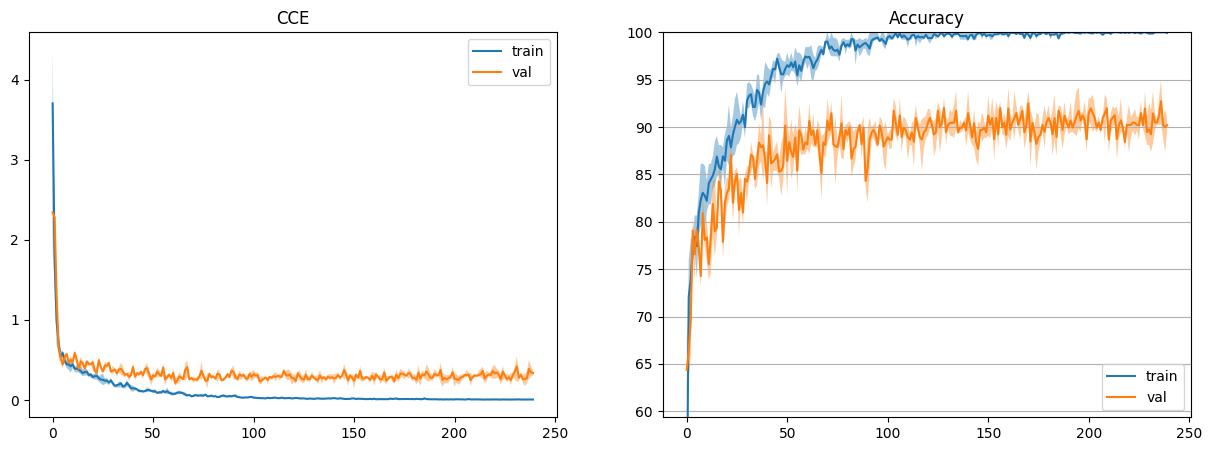

Обучение закончено за 30.632370710372925 секунд


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9)

EPOCHS = 250
REDRAW_EVERY = 20
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
for epoch in range(EPOCHS):
    tmp = []
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                  np.percentile(tmp, 25, axis=0),
                  np.percentile(tmp, 75, axis=0)))
    tmp = []
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    losses_val.append((np.mean(tmp, axis=0),
                      np.percentile(tmp, 25, axis=0),
                      np.percentile(tmp, 75, axis=0)))
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                          stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                          stats_val[:, 1, i],
                          stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
print('Обучение закончено за %s секунд' % passed)

In [9]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       500
          33     1.0000    1.0000    1.0000       500
          65     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

           0     0.9510    0.9700    0.9604       100
          33     0.8980    0.8800    0.8889       100
          65     0.8900    0.8900    0.8900       100

    accuracy                         0.9133       300
   macro avg     0.9130    0.9133    0.9131       300
weighted avg     0.9130    0.9133    0.9131       300

--------------------------------------------------


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Провести три обучения для 3 разных тактик пуллинга:
   1. Пуллинг с помощью шага свёртки stride,
   2. Макс пуллинг,
   3. Усредняющий пуллинг.

In [11]:
def train(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9)

  EPOCHS = 500
  REDRAW_EVERY = 20
  steps_per_epoch = len(dataloader['train'])
  steps_per_epoch_val = len(dataloader['test'])
  pbar = tqdm(total=EPOCHS*steps_per_epoch)
  losses = []
  losses_val = []
  passed = 0
  for epoch in range(EPOCHS):
      tmp = []
      model.train()
      for i, batch in enumerate(dataloader['train'], 0):
          inputs, labels = batch
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                      to(torch.float32).mean().cpu()*100
          tmp.append((loss.item(), accuracy.item()))
          pbar.update(1)
      losses.append((np.mean(tmp, axis=0),
                    np.percentile(tmp, 25, axis=0),
                    np.percentile(tmp, 75, axis=0)))
      tmp = []
      model.eval()
      with torch.no_grad():
          for i, data in enumerate(dataloader['test'], 0):
              inputs, labels = data
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model(inputs)
              loss = criterion(outputs, labels)
              accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                          to(torch.float32).mean().cpu()*100
              tmp.append((loss.item(), accuracy.item()))
      losses_val.append((np.mean(tmp, axis=0),
                        np.percentile(tmp, 25, axis=0),
                        np.percentile(tmp, 75, axis=0)))
      if (epoch+1) % REDRAW_EVERY != 0:
          continue
      clear_output(wait=False)
      passed += pbar.format_dict['elapsed']
      pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
      pbar.update((epoch+1)*steps_per_epoch)
      x_vals = np.arange(epoch+1)
      _, ax = plt.subplots(1, 2, figsize=(15, 5))
      stats = np.array(losses)
      stats_val = np.array(losses_val)
      ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
      ax[1].grid(axis='y')
      for i, title in enumerate(['CCE', 'Accuracy']):
          ax[i].plot(x_vals, stats[:, 0, i], label='train')
          ax[i].fill_between(x_vals, stats[:, 1, i],
                            stats[:, 2, i], alpha=0.4)
          ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
          ax[i].fill_between(x_vals,
                            stats_val[:, 1, i],
                            stats_val[:, 2, i], alpha=0.4)
          ax[i].legend()
          ax[i].set_title(title)
      plt.show()
  print('Обучение закончено за %s секунд' % passed)

In [12]:
def check(model):
  for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

### 1.

In [13]:
model.hidden_size = HIDDEN_SIZE
strideModel = model.stridePulling()
strideModel.to(device)
summary(strideModel, input_size=(32, 32, 3))
strideModel

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2             [-1, 64, 8, 8]           4,864
              ReLU-3             [-1, 64, 8, 8]               0
           Flatten-4                 [-1, 4096]               0
            Linear-5                    [-1, 3]          12,291
Total params: 17,155
Trainable params: 17,155
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.07
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


Sequential(
  (0): Normalize()
  (1): Conv2d(3, 64, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
  (2): ReLU()
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=4096, out_features=3, bias=True)
)

  0%|          | 0/6000 [00:00<?, ?it/s]

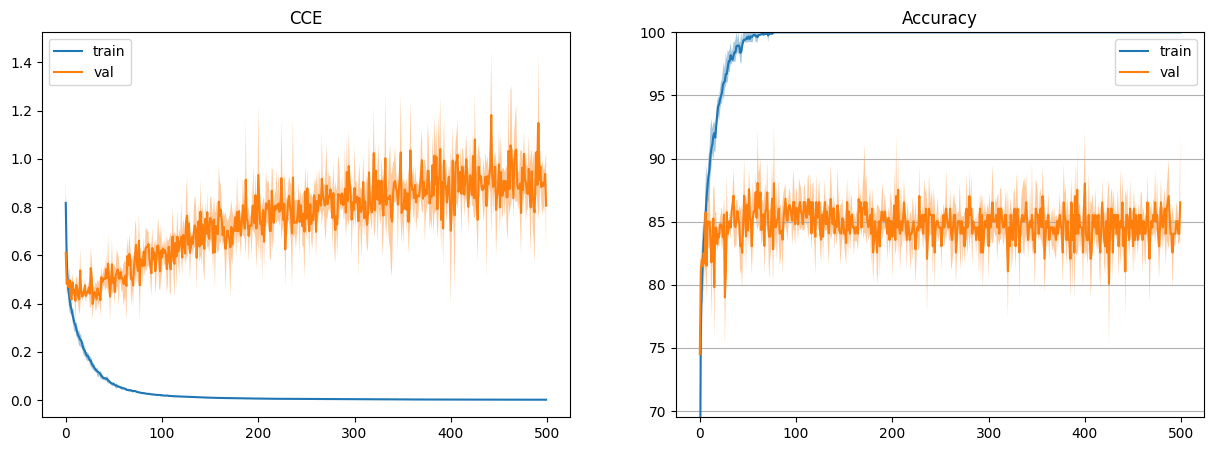

Обучение закончено за 32.60753512382507 секунд


In [14]:
train(strideModel)

In [15]:
check(strideModel)

train
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       500
          33     1.0000    1.0000    1.0000       500
          65     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

           0     0.9570    0.8900    0.9223       100
          33     0.7778    0.8400    0.8077       100
          65     0.8182    0.8100    0.8141       100

    accuracy                         0.8467       300
   macro avg     0.8510    0.8467    0.8480       300
weighted avg     0.8510    0.8467    0.8480       300

--------------------------------------------------


### 2.

In [16]:
model.hidden_size = HIDDEN_SIZE
maxPullingModel = model.maxPulling()
summary(maxPullingModel, input_size=(32, 32, 3))
maxPullingModel

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 64, 32, 32]           1,792
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
           Flatten-5                 [-1, 4096]               0
            Linear-6                    [-1, 3]          12,291
Total params: 14,083
Trainable params: 14,083
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.09
Params size (MB): 0.05
Estimated Total Size (MB): 1.15
----------------------------------------------------------------


Sequential(
  (0): Normalize()
  (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=4096, out_features=3, bias=True)
)

  0%|          | 0/6000 [00:00<?, ?it/s]

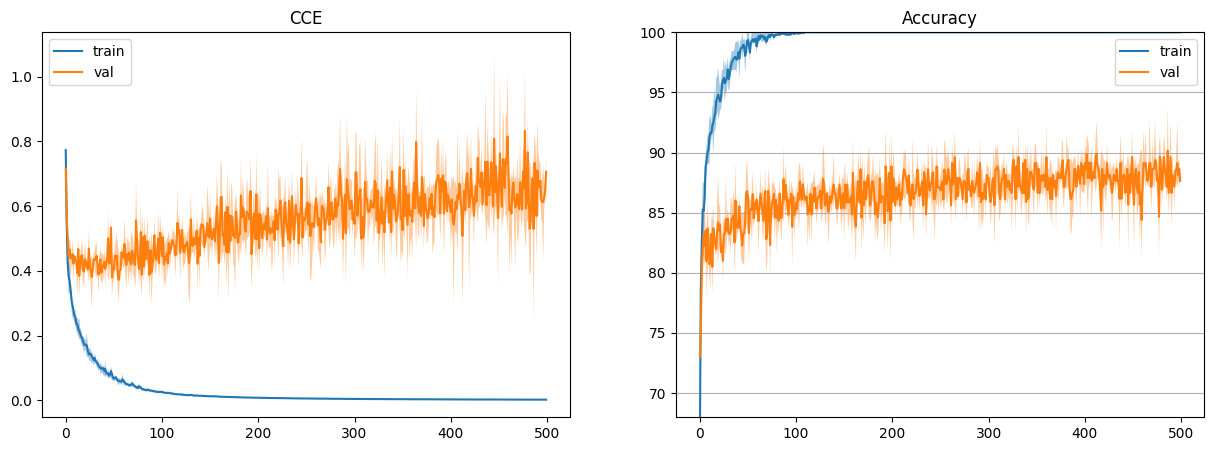

Обучение закончено за 40.79878544807434 секунд


In [17]:
train(maxPullingModel)

In [18]:
check(maxPullingModel)

train
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       500
          33     1.0000    1.0000    1.0000       500
          65     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

           0     0.9691    0.9400    0.9543       100
          33     0.8416    0.8500    0.8458       100
          65     0.8333    0.8500    0.8416       100

    accuracy                         0.8800       300
   macro avg     0.8813    0.8800    0.8806       300
weighted avg     0.8813    0.8800    0.8806       300

--------------------------------------------------


### 3.

In [19]:
model.hidden_size = HIDDEN_SIZE
averagePullingModel = model.averagePulling()
summary(averagePullingModel, input_size=(32, 32, 3))
averagePullingModel

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 64, 32, 32]           1,792
              ReLU-3           [-1, 64, 32, 32]               0
         AvgPool2d-4             [-1, 64, 8, 8]               0
           Flatten-5                 [-1, 4096]               0
            Linear-6                    [-1, 3]          12,291
Total params: 14,083
Trainable params: 14,083
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.09
Params size (MB): 0.05
Estimated Total Size (MB): 1.15
----------------------------------------------------------------


Sequential(
  (0): Normalize()
  (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=4096, out_features=3, bias=True)
)

  0%|          | 0/6000 [00:00<?, ?it/s]

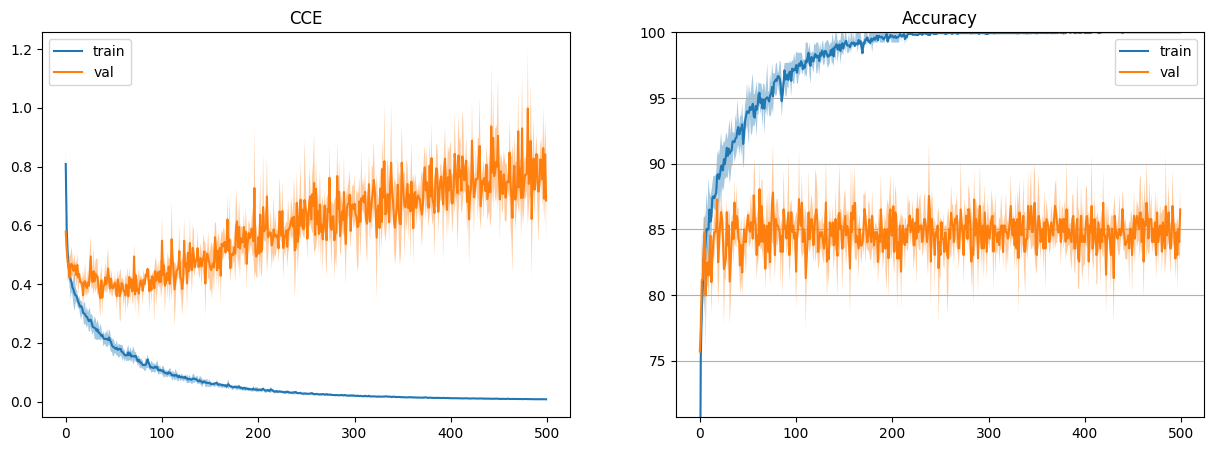

Обучение закончено за 40.39549016952515 секунд


In [20]:
train(averagePullingModel)

In [21]:
check(averagePullingModel)

train
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       500
          33     1.0000    1.0000    1.0000       500
          65     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

           0     0.9681    0.9100    0.9381       100
          33     0.7544    0.8600    0.8037       100
          65     0.8370    0.7700    0.8021       100

    accuracy                         0.8467       300
   macro avg     0.8531    0.8467    0.8480       300
weighted avg     0.8531    0.8467    0.8480       300

--------------------------------------------------


## Сохранение

In [22]:
PATH = 'cifar_cnn.pth'
torch.save(model.state_dict(), PATH)
# загрузка
new_model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar_cnn.pt'
torch.save(model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2, weights_only=False)
new_model_2.eval()

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): ReLU()
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=3, bias=True)
  )
)

In [23]:
!pip install onnx
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 17.0 MB/s eta 0:00:00


In [24]:
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_CNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})

/tmp/ipython-input-2577037542.py:5: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(model,               # модель
W0128 18:48:52.887000 1920 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 9 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `Cifar100_CNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Cifar100_CNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:68: adapter_lookup: Assertion `false`

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 2 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[s31,32,32,3]>
            ),
            outputs=(
                %"output"<FLOAT,[1,3]>
            ),
            initializers=(
                %"seq.1.bias"<FLOAT,[64]>{Tensor(...)},
                %"seq.5.bias"<FLOAT,[128]>{Tensor(...)},
                %"seq.10.bias"<FLOAT,[3]>{TorchTensor<FLOAT,[3]>(Parameter containing: tensor([-0.0575,  0.0388,  0.0100], device='cuda:0', requires_grad=True), name='seq.10.bias')},
                %"seq.0.mean"<FLOAT,[3]>{TorchTensor<FLOAT,[3]>(tensor([0.5074, 0.4867, 0.4411], device='cuda:0'), name='seq.0.mean')},
                %"seq.0.std"<FLOAT,[3]>{TorchTensor<FLOAT,[3]>(tensor([0.2011, 0.1987, 0.2025]